# cGAN using PixtoPix

In [1]:
import os
import pathlib
import time
import datetime
import matplotlib.pyplot as plt
from IPython import display
import tensorflow as tf


Downloading the dataset

In [2]:
tf.__version__

'2.12.0'

In [3]:
dataset = 'maps'

In [4]:
dataset_file ="{}.tar.gz".format(dataset)
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{}".format(dataset_file)
print(dataset_url)

http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz


In [5]:
download_zip = tf.keras.utils.get_file(fname = dataset_file, origin = dataset_url, extract =True)

250242400/250242400 [==============================] - 108s 0us/step


In [6]:
download_zip = pathlib.Path(download_zip)
path = download_zip.parent/dataset

In [7]:
path

PosixPath('/root/.keras/datasets/maps')

In [8]:
list(path.parent.iterdir())

[PosixPath('/root/.keras/datasets/maps.tar.gz'),
 PosixPath('/root/.keras/datasets/maps')]

In [9]:
sample = tf.io.read_file(str(path/'train/1.jpg'))
sample = tf.io.decode_jpeg(sample)

In [10]:
print(sample.shape)

(600, 1200, 3)


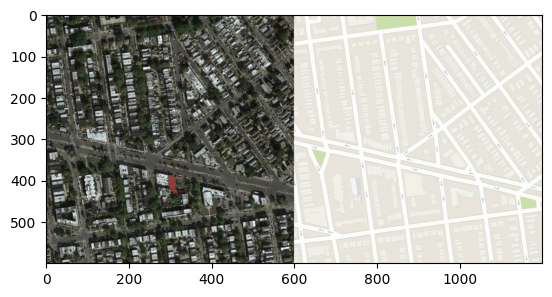

In [11]:
# Visualising the image
plt.figure()
plt.imshow(sample)

In [12]:
sample = tf.io.read_file(str(path/'train/3.jpg'))
sample = tf.io.decode_jpeg(sample)

(600, 1200, 3)


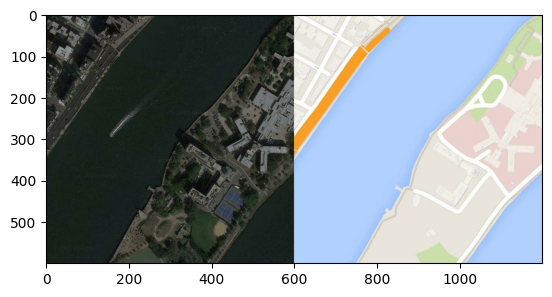

In [13]:
# Visualising the image
plt.figure()
plt.imshow(sample)
print(sample.shape)

Function to preprocessing

In [14]:
# # The image we have in dataset are attached with each other,
#  we need to separate them in order to  get used
#   in the mode

def load_image(img_file):
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)
  img = tf.image.resize(img, [256, 512])

  #print shape
  width = tf.shape(img)[1]

  #print width
  width = width // 2    #// used instead of / to get integer value instead of float

  #dividing the images of dataset
  original_img = img[: , :width,:]  #(height, width, channel)
  transformed_img = img[:, width:,:]

  original_img = tf.cast(original_img, tf.float32)
  transformed_img = tf.cast(transformed_img, tf.float32)

  return original_img, transformed_img



In [15]:
original_img, transformed_img = load_image(str(path / 'train/3.jpg'))
original_img.shape, transformed_img.shape

(TensorShape([256, 256, 3]), TensorShape([256, 256, 3]))

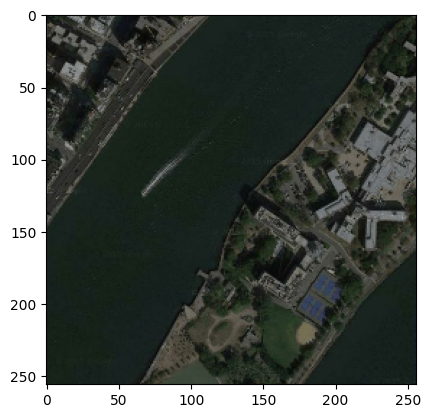

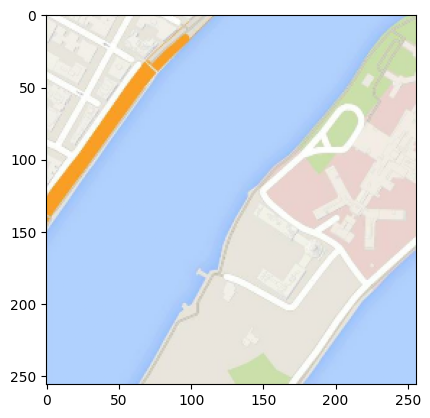

In [16]:
plt.figure()
plt.imshow(original_img/255.0)
plt.figure()
plt.imshow(transformed_img/255.0)

In [17]:
original_img, transformed_img = load_image(str(path / 'train/1.jpg'))
original_img.shape, transformed_img.shape

(TensorShape([256, 256, 3]), TensorShape([256, 256, 3]))

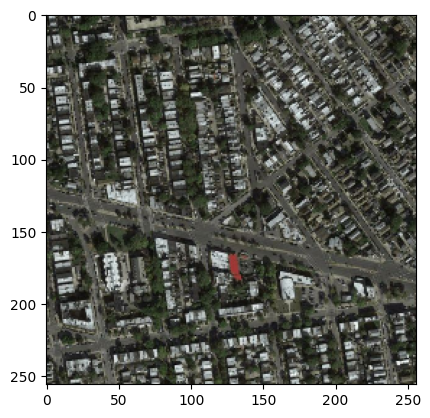

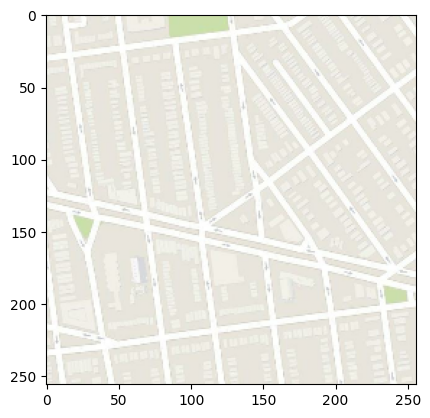

In [18]:
plt.figure()
plt.imshow(original_img/255.0)
plt.figure()
plt.imshow(transformed_img/255.0)

In [19]:
#length of training images
quantity_training = tf.data.Dataset.list_files(str(path/'train/*.jpg'))
quantity_training

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [20]:
buffer_size = quantity_training
batch_size =1
img_width = 256
img_height = 256

In [21]:
# resizing the images to size(256, 256)
def resize(original_img, transformed_img, width, height):
  original_img = tf.image.resize(original_img,[width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  transformed_img = tf.image.resize(transformed_img,[width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return original_img, transformed_img

In [22]:

# normilization to bring th epixel from 0-255 range to -1 to 1
def normalize(original_img, transformed_img):
  original_img = (original_img/127.5)-1
  transformed_img = (transformed_img/127.5)-1
  return original_img, transformed_img

In [23]:
def random_crop(original_img, transformed_img):
  stacked_img = tf.stack([original_img, transformed_img], axis = 0)
  crop_img = tf.image.random_crop(stacked_img, size = [2, img_width, img_height, 3])
  return crop_img[0], crop_img[1]

In [24]:
tf.random.uniform(())  #generates random value in between 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.2036519>

In [25]:
# applying all functions to preprocess
@tf.function()
def random_jitter(original_img, transformed_img):
  original_img, transformed_img = resize(original_img, transformed_img, 286, 286)
  original_img, transformed_img = random_crop(original_img, transformed_img)
  if tf.random.uniform(()) > 0.5:
    original_img = tf.image.flip_left_right(original_img)
    transformed_img = tf.image.flip_left_right(transformed_img)
  return original_img, transformed_img

random_jitter is a TensorFlow function that applies several preprocessing steps to a pair of images, original_img and transformed_img, as part of data augmentation. These preprocessing steps include resizing, random cropping, and random horizontal flipping. Let's break down what each step does:

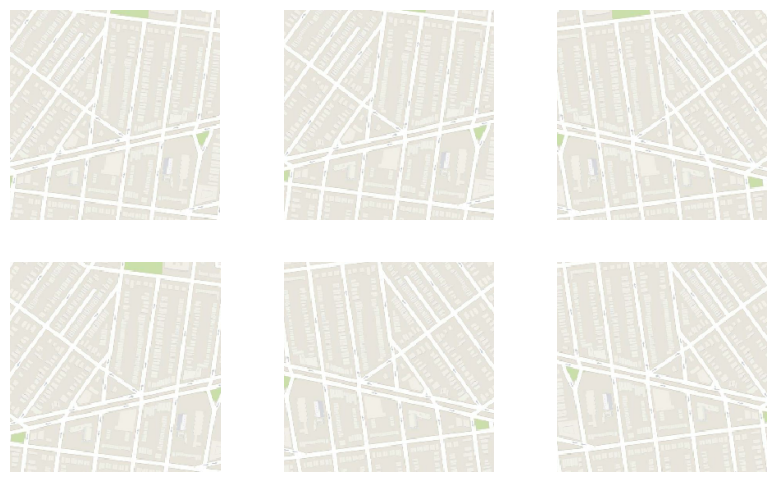

In [26]:
plt.figure(figsize = (10,6))
for i in range(6):
  j_original, j_transformed = random_jitter(original_img, transformed_img)
  plt.subplot(2,3, i + 1)
  plt.imshow(j_transformed / 255.0)
  plt.axis('off')
plt.show()

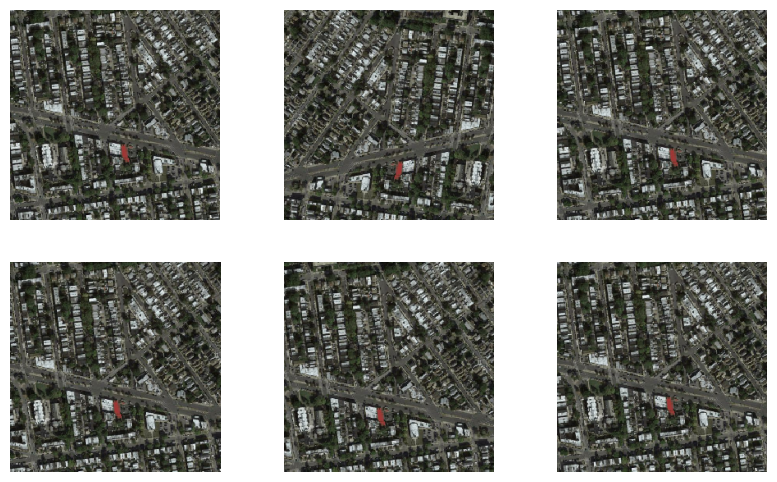

In [27]:
plt.figure(figsize = (10,6))
for i in range(6):
  j_original, j_transformed =  random_jitter(original_img,transformed_img)
  plt.subplot(2,3,i+1)
  plt.imshow(j_original/255.0)
  plt.axis('off')
plt.show()

In [28]:
# loading dataset in tensorflow format

def load_training_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = random_jitter(original_img, transformed_img)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [29]:
#hhere, random_jitter is not used since, test data it is, we are not going to flip it
def load_testing_images(img_file):
  original_img, transformed_img = load_image(img_file)
  original_img, transformed_img = resize(original_img, transformed_img, img_width, img_height)
  original_img, transformed_img = normalize(original_img, transformed_img)
  return original_img, transformed_img

In [30]:
training_dataset = tf.data.Dataset.list_files(str(path / 'train/*.jpg'))
training_dataset = training_dataset.map(load_training_images, num_parallel_calls=tf.data.AUTOTUNE)
# training_dataset = training_dataset.shuffle(buffer_size)
training_dataset = training_dataset.batch(batch_size)

In [31]:
training_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

In [32]:
try:
  testing_dataset = tf.data.Dataset.list_files(str(path / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:    #if this type of error is found then use val file for validation
  testing_dataset = tf.data.Dataset.list_files(str(path / 'val/*.jpg'))
testing_dataset = testing_dataset.map(load_testing_images)
testing_dataset = testing_dataset.batch(batch_size)

## **Generator**

## Generator

The generator is a modified version of [U-Net](https://paperswithcode.com/method/u-net).

U-Net components:
* Encoder (downsampler)
* Decoder (upsampler)

More about U-Net:
* https://paperswithcode.com/method/u-net
* https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

*Downsample / encode**
 * Convolution -> Batch normalization -> Leaky ReLU

In [33]:
def encode(filters, size, apply_batchnorm = True):
  initializer = tf.random_normal_initializer(0, 0.02) #initialising the weights
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                                    kernel_initializer=initializer, use_bias=False))
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [34]:
original_img.shape

TensorShape([256, 256, 3])

In [35]:
down_model = encode(3, 4)   #conv layer with 3 filters and size =(4,4), this is the filter size
down_result = down_model(tf.expand_dims(original_img, 0))
print(down_result.shape)

(1, 128, 128, 3)


**Upsample / decode**
 * Transposed convolution -> Batch normalization -> Dropout (applyed for the first 3 blocks) -> ReLU

In [36]:
def decode(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0, 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                                             kernel_initializer=initializer, use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [37]:
up_model = decode(3, 4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


so, we created function for encoder and decoder for generator. Now, we buid the generator by aligning these functions

In [38]:
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])

  # putting all layers each for downsample and upsample ina lis
  downsampling = [
      encode(64, 4, apply_batchnorm = False), # (batch_size, 128, 128, 64)
      encode(128, 4), # (batch_size, 64, 64, 128)
      encode(256, 4), # (batch_size, 32, 32, 256)
      encode(512, 4), # (batch_size, 16, 16, 512)
      encode(512, 4), # (batch_size, 8, 8, 512)
      encode(512, 4), # (batch_size, 4, 4, 512)
      encode(512, 4), # (batch_size, 2, 2, 512)
      encode(512, 4), # (batch_size, 1, 1, 512)
  ]

  upsampling = [
      decode(512, 4, apply_dropout=True), # (batch_size, 2, 2, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 4, 4, 512)
      decode(512, 4, apply_dropout=True), # (batch_size, 8, 8, 512)
      decode(512, 4), # (batch_size, 16, 16, 512)
      decode(256, 4), # (batch_size, 32, 32, 256)
      decode(128, 4), # (batch_size, 64, 64, 128)
      decode(64, 4), # (batch_size, 128, 128, 64)
  ]

  output_channels = 3
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same',
                                         kernel_initializer=initializer, activation='tanh') # (batch_size, 256, 256, 3)
  #making  skip connections
  x = inputs
  skips = []
  for down in downsampling:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(upsampling, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)


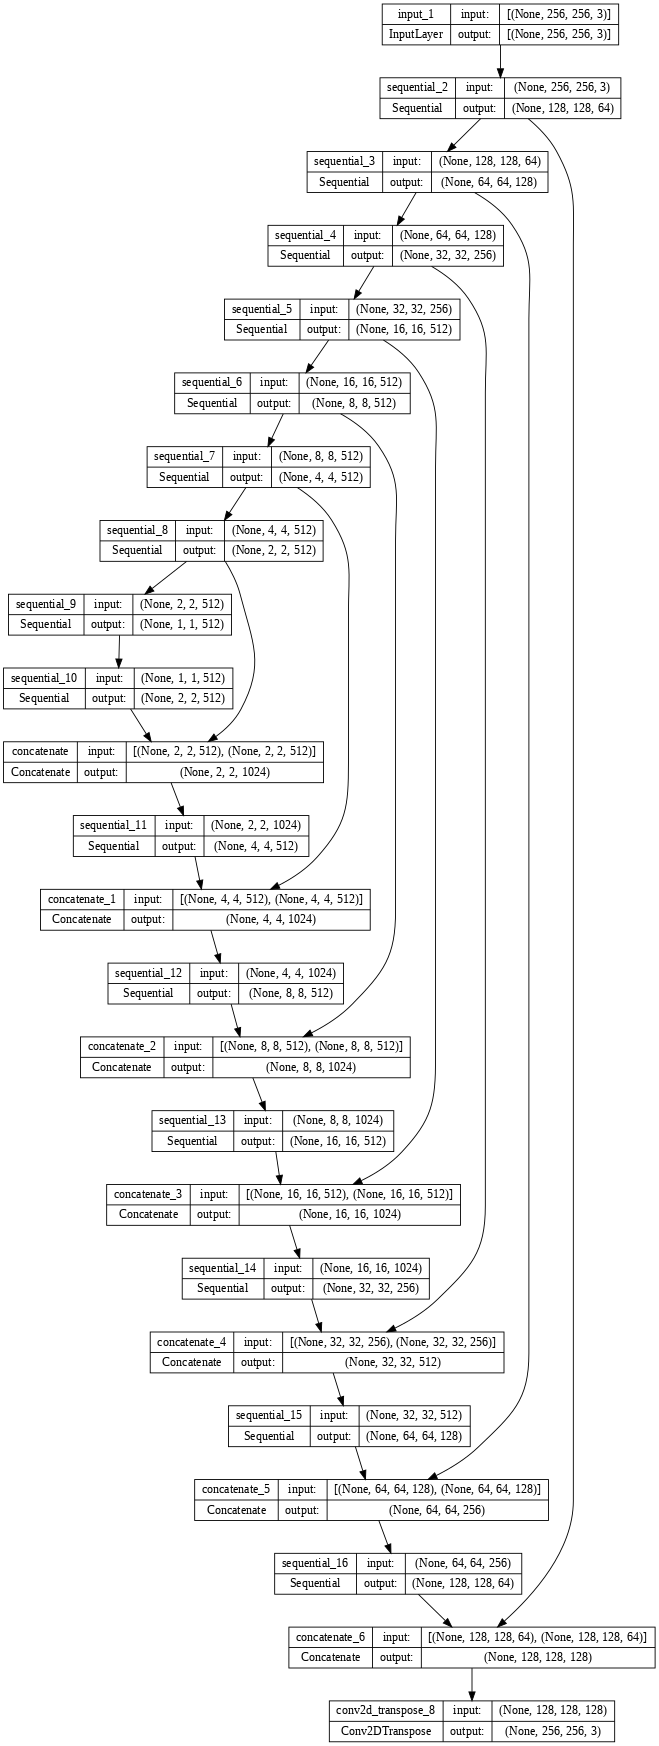

In [39]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 64)

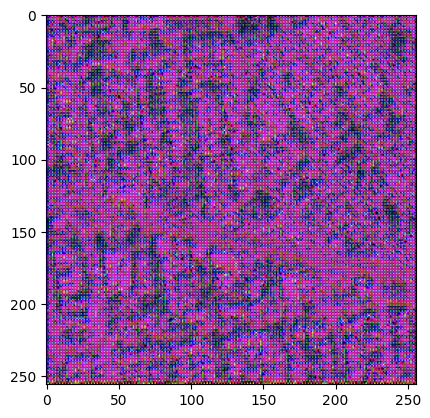

In [40]:
# Testin the architecture we have generated

g_output = generator(original_img[tf.newaxis, ...], training=False)
plt.imshow(g_output[0, ...])  #[... are height, width, channels respectively] and new axis added to be compatible with tensorflow


Since, the model has not been trained yet, the output is like this

### Generator loss

Normal GANs learn loss that adapts to the data, while cGAN learns structured loss that penalizes a possible structure that differs from the network output and the expected "real" image. More details: https://arxiv.org/abs/1611.07004


In [41]:
# hyperparameter
lr = 0.0002
beta1, beta2 = 0.5, 0.999
lambda_ = 100

In [42]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [43]:
def generator_loss(d_generated_output, g_output, target):
  gan_loss = loss(tf.ones_like(d_generated_output), d_generated_output)
  l1_loss = tf.reduce_mean(tf.abs(target - g_output)) # MAE
  g_loss_total = gan_loss + (lambda_ * l1_loss)
  return g_loss_total, gan_loss, l1_loss

## Discriminator

The discriminator is a [PatchGAN](https://paperswithcode.com/method/patchgan). The goal is to classify if each patch (piece) of the image is real or fake.

* Blocks of the discriminator: Convolution -> Batch normalization -> Leaky ReLU.

* The output shape is `(batch_size, 30, 30, 1)`

More information: https://arxiv.org/abs/1611.07004

The discriminator receives two inputs:
  1. The input image and the expected image, which should be classified as real
  2. The input image and the generated image (fake, generated by the generator), which should be classified as fake.

In [44]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  original = tf.keras.layers.Input(shape = [256,256,3], name='original_img')
  transformed = tf.keras.layers.Input(shape=[256,256,3], name='transformed_img')
  x = tf.keras.layers.concatenate([original, transformed]) # (batch_size, 256, 256, channels * 2)

  down1 = encode(64, 4, False)(x) # (batch_size, 128, 128, 64)
  down2 = encode(128, 4)(down1) # (batch_size, 64, 64, 128)
  down3 = encode(256, 4)(down2) # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides = 1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides = 1, kernel_initializer=initializer)(zero_pad2) # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs = [original, transformed], outputs = last)

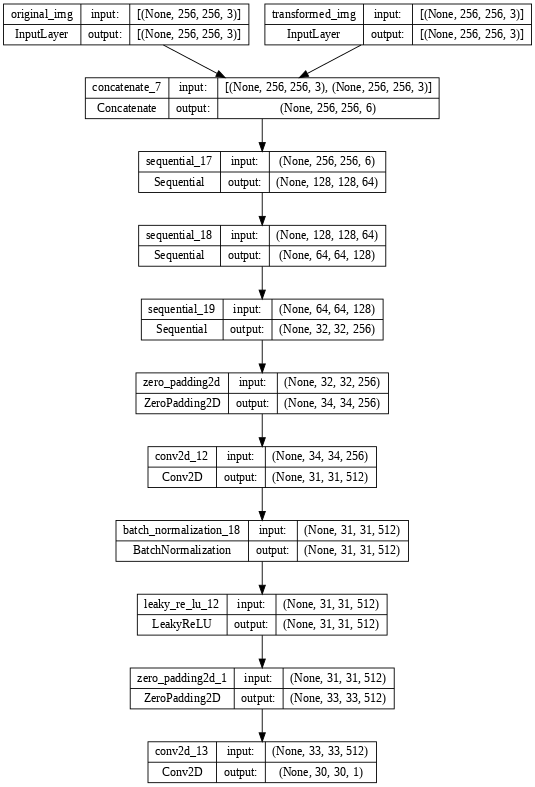

In [45]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes = True, dpi = 64)

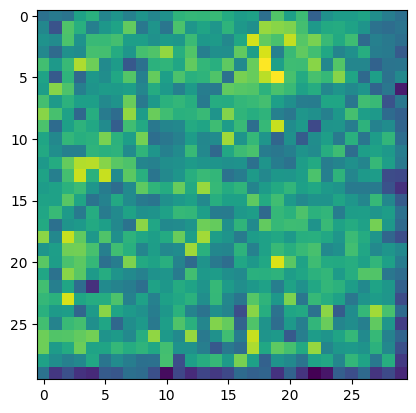

In [46]:
d_output = discriminator([original_img[tf.newaxis, ...], g_output], training=False)
plt.imshow(d_output[0, ..., -1]) #image 0, first is taken , ...,are dimensions , -1 is we want last position only

### Discriminator loss

It receives two inputs: real images and generated (fake) images
* `real_loss` - sigmoid cross-entropy loss comparing the **real** image and one array of 1's
* `generated_loss (fake)` - sigmoid cross-entropy loss comparing the **generated** image and one array of 0's

The total loss is a sum of both losses

In [47]:
def discriminator_loss(d_real_output, d_generated_output):
  real_loss = loss(tf.ones_like(d_real_output), d_real_output)
  generated_loss = loss(tf.zeros_like(d_generated_output), d_generated_output)
  d_total_loss = real_loss + generated_loss
  return d_total_loss

In [48]:
## Optimizers



In [49]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1 = beta1, beta_2 = beta2)

## Model checkpoint


In [50]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Generating images

In [51]:
def generate_images(model, test_input, real, step = None):
  generated_img = model(test_input, training=True)
  plt.figure(figsize=(12,8))

  img_list = [test_input[0], real[0], generated_img[0]]
  title = ['Input image', 'Real (ground truth)', 'Generated image (fake)']

  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(title[i])
    plt.imshow(img_list[i] * 0.5 + 0.5)
    plt.axis('off')

  if step is not None:
    plt.savefig('result_pix2pix_step_{}.png'.format(step), bbox_inches='tight')

  plt.show()

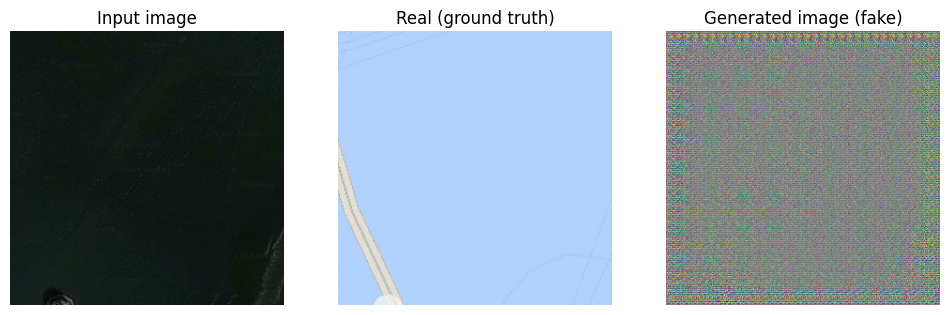

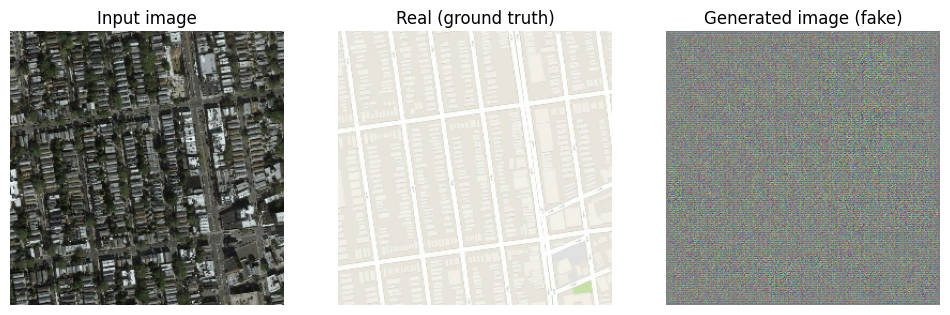

In [52]:
for input_example, real_example in testing_dataset.take(2):
  generate_images(generator, input_example, real_example)

## Training

* For each input, an output is generated.
* The discriminator receives input_img and the generated images as the first input. The second input is img_entry and the "real" (expected)
* Then, the loss of the generator and discriminator is calculated
* Then we calculate the loss gradients with respect to the generator and discriminator variables (inputs) and apply these to the optimizer.

In [53]:
path_log = 'logs/'
metrics = tf.summary.create_file_writer(path_log + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [54]:
@tf.function
def training_step(input_img, real, step):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    g_output = generator(input_img, training = True)

    d_output_real = discriminator([input_img, real], training = True)
    d_output_generated = discriminator([input_img, g_output], training = True)

    g_total_loss, g_loss_gan, g_loss_l1 = generator_loss(d_output_generated, g_output, real)
    d_loss = discriminator_loss(d_output_real, d_output_generated)

  generator_gradients = g_tape.gradient(g_total_loss, generator.trainable_variables)
  discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with metrics.as_default():
    tf.summary.scalar('g_total_loss', g_total_loss, step=step//1000)
    tf.summary.scalar('g_loss_gan', g_loss_gan, step=step//1000)
    tf.summary.scalar('g_loss_l1', g_loss_l1, step=step//1000)
    tf.summary.scalar('d_loss', d_loss, step=step//1000)

In [55]:
def train(training_dataset, testing_dataset, steps):
  test_input, real_input = next(iter(testing_dataset.take(1)))
  start = time.time()

  for step, (input_img, real_img) in training_dataset.repeat().take(steps).enumerate():
    if step % 1000 == 0:
      display.clear_output(wait = True)
      if step != 0:
        print(f'Time taken to run 1000 steps: {time.time() - start:.2f} seconds\n')
      start = time.time()
      generate_images(generator, test_input, real_input, step)
      print(f'Step: {step//1000}K')
    training_step(input_img, real_img, step)
    if (step + 1) % 10 == 0:
      print('.', end = '', flush = True)
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      generator.save_weights('model_pix2pix.h5')

Time taken to run 1000 steps: 91.54 seconds



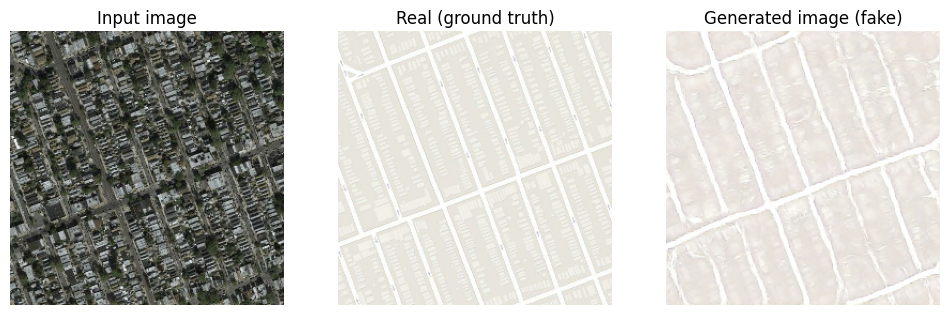

Step: 19K
....................................................................................................

In [56]:
train(training_dataset, testing_dataset, steps = 20000) # 40000

### Comments about training

* Note that neither the generator nor the discriminator "win" over each other. If either the `g_loss_gan` or the `d_loss` are too low, it is an indicator that one is dominating the other, which means that it is not training the two together as it should.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates that the discriminator is generally uncertain about its evaluation (true or false)
* Considering `d_loss`, a value below 0.69 means that the discriminator is doing better than a random classification on the combined set of real and generated images.
* Considering `g_loss_gan`, a value below 0.69 means that the trained generator is fooling the discriminator better than if it were just random generation
* During training, `g_loss_l1` should decrease.

checkpoint restoration

In [57]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt-4'

In [58]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Time taken to run 1000 steps: 92.22 seconds



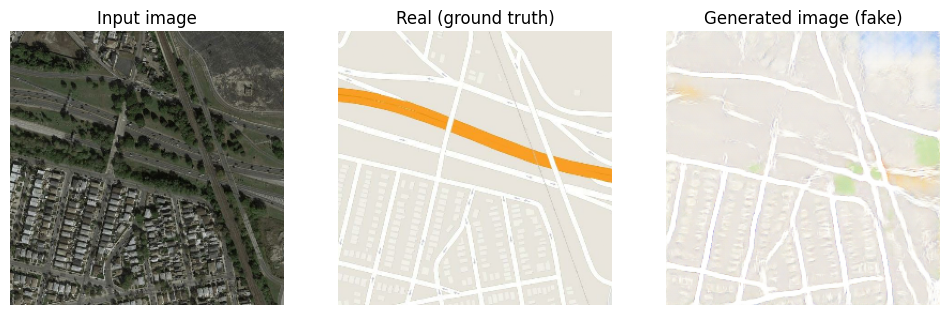

Step: 19K
....................................................................................................

In [59]:
train(training_dataset, testing_dataset, steps = 20000) # 40000

In [60]:
model2 = Generator()
model2.load_weights('/content/model_pix2pix.h5')

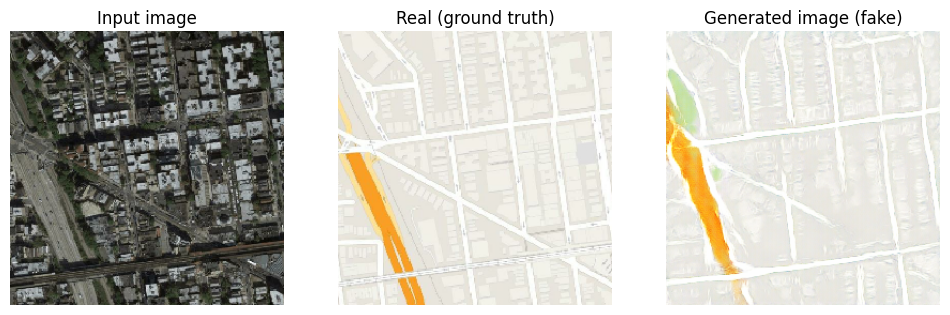

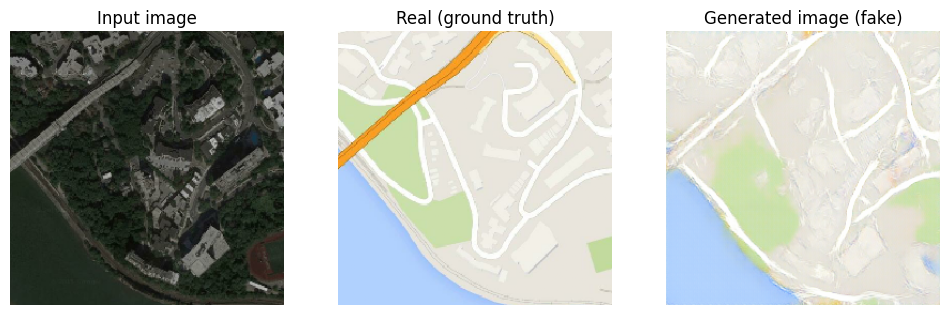

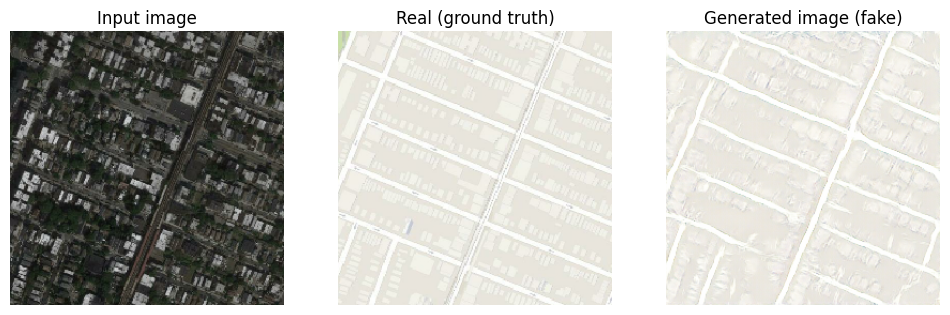

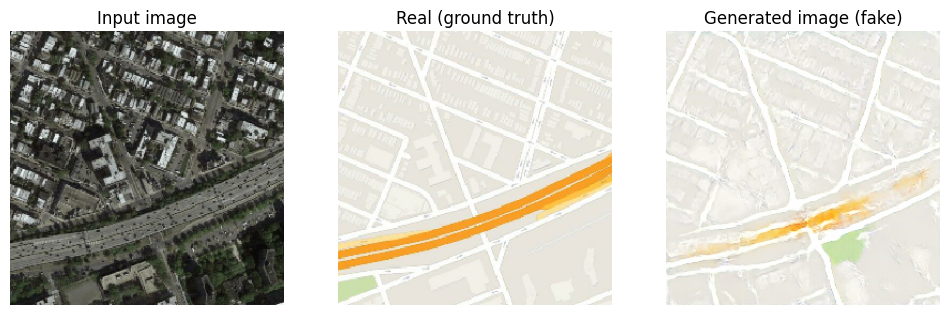

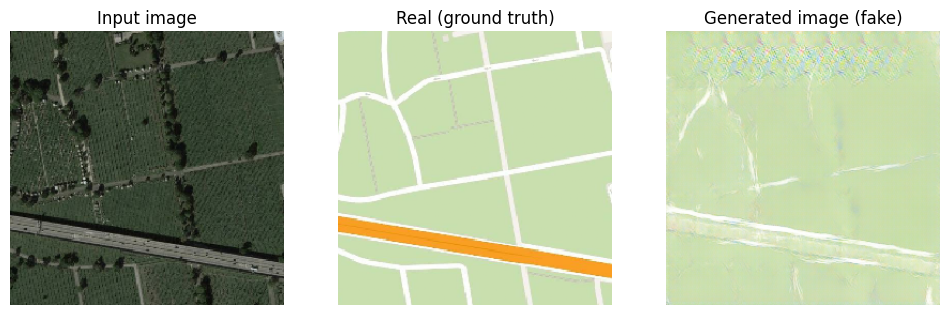

In [61]:
for s, m in training_dataset.take(5):
  generate_images(model2, s, m)